# Pennsbury High School Tweet Analysis

## Accessing Twitter

In [12]:
import twitter
import json

def oauth_login():
    # XXX: Go to  to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
    # for more information on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'ldJnCzzuCM3Col1pMcmSyVaDT'
    CONSUMER_SECRET = 'RWCNFVehlhAHzarhuAJA7vjSfoQx1FB96HLY7VR2U1d6mDj31w'
    OAUTH_TOKEN = '1112769260818972672-FFlTewXnvPcbcJAM04vYqk8DPxjYcG'
    OAUTH_TOKEN_SECRET = 'D5EuZziAVsW26tHuZCGYRw2uiKPdfdUgaaIszGatEsdB6'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

print(twitter_api)

## Searching for tweets

In [13]:
def twitter_search(twitter_api, q, max_results=200, **kw):
    
    search_results = twitter_api.search.tweets(q=q, count=100, **kw)
    
    statuses = search_results['statuses']
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://developer.twitter.com/en/docs/basics/rate-limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    # Read this https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines to understand why we use 
    # max_id to populate tweets
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

# Sample usage

twitter_api = oauth_login()

q = "Pennsbury High School"
results = twitter_search(twitter_api, q, max_results=1000)

In [14]:
for i in range(5):
    print()
    print(results[i]['text'])
    print('Favorites: ',results[i]['favorite_count'])
    print('Retweets: ', results[i]['retweet_count'])


Sending love and a huge thank you to Pennsbury HS for their amazingly kind donation of some of their prom artwork f… https://t.co/jehVaKghRF
Favorites:  2
Retweets:  0

RT @levittownnow: Would you be interested in a hard cover or soft cover book featuring more than 100 curated photos from Pennsbury High Sch…
Favorites:  0
Retweets:  1

Would you be interested in a hard cover or soft cover book featuring more than 100 curated photos from Pennsbury Hi… https://t.co/BWJKRFex5J
Favorites:  0
Retweets:  1

RT @WBCBNews: Pennsbury High School’s senior prom was back and better than ever Saturday night.

https://t.co/ZQ91aCDGrw
Favorites:  0
Retweets:  1

Pennsbury High School’s senior prom was back and better than ever Saturday night.

https://t.co/ZQ91aCDGrw
Favorites:  1
Retweets:  1


## Extracting text, screen names, and hashtags from tweets

In [15]:
status_texts = [ status['text']
                 for status in results ]

screen_names = [ user_mention['screen_name']
                 for status in results
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text']
             for status in results
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w
          for t in status_texts
              for w in t.split() ]

## Simple frequency analysis

In [16]:
from collections import Counter
from prettytable import PrettyTable

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    c.most_common()[:10]
    
for label, data in (('Word', words),
                    ('Screen Name', screen_names),
                    ('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count'])
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:10] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+-----------+-------+
| Word      | Count |
+-----------+-------+
| Pennsbury |    47 |
| High      |    45 |
| School    |    32 |
| the       |    24 |
| RT        |    22 |
| Prom      |    22 |
| @         |    20 |
| in        |    18 |
| I         |    15 |
| A         |    15 |
+-----------+-------+
+----------------+-------+
| Screen Name    | Count |
+----------------+-------+
| DJPaulyD       |    12 |
| FallsTwpPolice |     5 |
| DrewHensor     |     3 |
| pennsburyfb    |     3 |
| EPAFootball    |     2 |
| levittownnow   |     1 |
| WBCBNews       |     1 |
| thermoHailine  |     1 |
| PatrickEddis   |     1 |
| CorbinRadul316 |     1 |
+----------------+-------+
+-------------------+-------+
| Hashtag           | Count |
+-------------------+-------+
| BestPromInAmerica |    12 |
| prom2019          |    12 |
| Pennsbury         |     8 |
| pennsburyprom     |     5 |
| SeniorProm        |     2 |
| pennsburyprom2019 |     1 |
| musicofthedecades |     1 |
+-------------

In [17]:
retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in results 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(set(retweets), reverse=True)[:5] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)

+-------+----------------+---------------------+----------------------------------------------------+
| Count | Screen Name    | Tweet ID            | Text                                               |
+-------+----------------+---------------------+----------------------------------------------------+
| 32    | DJPaulyD       | 1135152234214428674 | RT @DJPaulyD: I Love Prom This Time A Yearrrrr!!!! |
|       |                |                     | 🙌🏽🙌🏽 #BestPromInAmerica #prom2019🎓 U Guys Rock!! @ |
|       |                |                     | Pennsbury High School https://t.co/lS…             |
| 6     | FallsTwpPolice | 1133813552224067584 | RT @FallsTwpPolice: Please help this male terrier  |
|       |                |                     | get home!   He was found by Pennsbury High School  |
|       |                |                     | on May 28th.  Please contact the Bucks…            |
| 5     | EPAFootball    | 1134430803671289856 | RT @EPAFootball: Player Previews 

## Visualizing word frequencies

In [18]:
import wordcloud

words

wc = wordcloud.WordCloud(stopwords=['https','RT','CO'])
clean_string = ','.join(words)
wc.generate(clean_string)

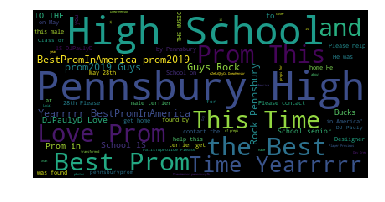

In [19]:
plt.imshow(wc.recolor( random_state=3))
plt.axis('off')
plt.show()

Step 2: run sentiment analysis on the tweets included in the hashtags

***Cells below oar from Week3a-TwitterMining-new

In [ ]:
import nltk
nltk.download('vader_lexicon')

# Polarity Ranking of Results

In [ ]:
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

scores = np.zeros(len(results))

for i, t in enumerate(results):
    # Extract the text portion of the tweet
    text = t['text']

    # Measure the polarity of the tweet
    polarity = analyzer.polarity_scores(text)

    # Store the normalized, weighted composite score
    scores[i] = polarity['compound']

most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

print('{0:6.3f} : "{1}"'.format(scores[most_positive], results[most_positive]['text']))

print('{0:6.3f} : "{1}"'.format(scores[most_negative], results[most_negative]['text']))

Step 4: Create word maps of the words in the tweets that cross the threashhold

***Cells below are from Week2-TwitterMining workbook and have not been formated.

In [ ]:
status_texts = [ status['text']
                 for status in results ]

screen_names = [ user_mention['screen_name']
                 for status in results
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text']
             for status in results
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w
          for t in status_texts
              for w in t.split() ]

# Explore the first 5 items for each...

print(json.dumps(status_texts[0:5], indent=1))
print(json.dumps(screen_names[0:5], indent=1))
print(json.dumps(hashtags[0:5], indent=1))
print(json.dumps(words[0:5], indent=1))

In [ ]:
from collections import Counter

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10
    print()

In [ ]:
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline

word_counts = sorted(Counter(words).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [ ]:
import wordcloud

In [ ]:
words

In [ ]:
wc = wordcloud.WordCloud(stopwords=['https','RT','CO'])
clean_string = ','.join(words)
wc.generate(clean_string)

In [ ]:
plt.imshow(wc.recolor( random_state=3))
plt.axis('off')
plt.show()


Step 5: Create a network of the users bc of their followers/who they follow

-would have to account for users who have tweeted multiple times, should we do this when saving the sentiment analysis/user/tweet so users can have multiple tweets or would we sort through when creating the network to find users with multiple tweets

***Cells below are from Networkx_twitter and have not been formated

In [ ]:
import json
f = open('./data/friends/list.PyTennessee.json')

data = json.load(f)
pairs = []

for user in data['users']:
    pairs.append(('PyTennessee', str(user['screen_name'])))

pairs[:10]

In [ ]:
# Because the relationship data is split across files, we need to
# walk through all of them to get the data.
import os

for (dir_path, dir_names, file_names) in os.walk('./data/friend_relationships/'):
    files = file_names
    
for file_name in files:
    with open('./data/friend_relationships/' + file_name) as p:
        pair_data = json.load(p)
        for k in pair_data.keys():
            twitter_pair = k.split()
            if pair_data[k]['relationship']['source']['following'] is True:
                pairs.append((str(twitter_pair[0]), str(twitter_pair[1])))
            elif pair_data[k]['relationship']['source']['followed_by'] is True:
                pairs.append((str(twitter_pair[1]), str(twitter_pair[0])))
                
len(pairs)

In [ ]:
%matplotlib inline
import networkx as nx
import operator
import matplotlib.pyplot as plt

In [ ]:
# Build an undirected graph. What's going on?
g = nx.Graph()
g.add_edges_from(pairs)
nx.draw_networkx(g,font_size=6)
plt.axis('off')
plt.savefig('undirected.png', dpi=500)
# How connected is the network?
# Very connected!

In [ ]:
# Hint: if you want to sort a dictionary to easily 
# find the highest and lowest values, use this function 
# on the output of the centrality measures like degree_centrality():

import operator

def centrality_sort(centrality_dict):
    return sorted(centrality_dict.items(), key=operator.itemgetter(1))

# ex. degree_sorted = centrality_sort(degree_vals)

In [ ]:
# Centrality: which nodes have the highest/lowest degree centrality?
degree_centrality = nx.degree_centrality(g)
degree_sorted = centrality_sort(degree_centrality)
print ('-------------Degree Centrality-------------')
print ('Highest degree:', degree_sorted[-5:])
print ('\n')
print ('Lowest degree:', degree_sorted[:5])
print ('\n')

In [ ]:
# Centrality: which nodes have the highest/lowest betweenness centrality?
betweenness = nx.betweenness_centrality(g)
betweenness_sorted = centrality_sort(betweenness)
print ('-------------Betweenness Centrality-------------')
print ('Highest betweenness:', betweenness_sorted[-5:])
print ('\n')
print ('Lowest betweenness:', betweenness_sorted[:5])
print ('\n')

In [ ]:
# Centrality: which nodes have the highest/lowest closeness centrality?
closeness = nx.closeness_centrality(g)
closeness_sorted = centrality_sort(closeness)
print ('-------------Closeness Centrality-------------')
print ('Highest closeness:', closeness_sorted[-5:])
print ('\n')
print ('Lowest closeness:', closeness_sorted[:5])

# At the end, discuss these questions more in-depth.

In [ ]:
# Let's look at subsections of the graph.

# Top 20 highest in-degree centrality scores:
highest_degree = [node[0] for node in degree_sorted[-20:]]
sub = g.subgraph(highest_degree)
nx.draw_networkx(sub)
plt.axis('off');

In [ ]:
lowest_degree = [node[0] for node in degree_sorted[:20]]
subl = g.subgraph(lowest_degree)
nx.draw_networkx(subl)
plt.axis('off');

In [ ]:
# Directed graph

d = nx.DiGraph()

d.add_edges_from(pairs)
nx.draw_networkx(d)
plt.axis('off');

In [ ]:
# Run some degree centrality measures for directed graphs:
# in_degree_centrality(): number of incoming connections (number of people following you)
# out_degree_centrality(): number of outgoing connections (number of people you follow)
in_degree_centrality = nx.in_degree_centrality(d)
in_degree_sorted = sorted(in_degree_centrality.items(), key=operator.itemgetter(1))
print ('-------------Degree Centrality-------------')
print ('Highest in degree:', in_degree_sorted[-5:])
print ('\n')
print ('Lowest in degree:', in_degree_sorted[:5])
print ('\n')

out_degree_centrality = nx.out_degree_centrality(d)
out_degree_sorted = sorted(out_degree_centrality.items(), key=operator.itemgetter(1))
print ('-------------Degree Centrality-------------')
print ('Highest out degree:', out_degree_sorted[-5:])
print ('\n')
print ('Lowest out degree:', out_degree_sorted[:5])

In [ ]:
# Let's look at subsections of the graph. Just like we did above.

# Top 20 highest in-degree centrality scores:
highest_in_degree = [node[0] for node in in_degree_sorted[-20:]]
subin = d.subgraph(highest_in_degree)
nx.draw_networkx(subin)
plt.axis('off');

In [ ]:
# Top 20 highest out-degree centrality scores:
highest_out_degree = [node[0] for node in out_degree_sorted[-20:]]
subin = d.subgraph(highest_out_degree)
nx.draw_networkx(subin)
plt.axis('off');

In [ ]:
import networkx as nx

# we need this 'magic' command to draw graphs inline
%matplotlib inline  

g = nx.Graph()

# let's attach a size attribute to each node to describe how big we want the node to be
g.add_node(1, size= 800)
g.add_node(2, size= 200)
g.add_node(3, size= 200)
g.add_node(4, size= 200)
g.add_node(5, size= 200)

g.add_edge(1,2, thickness= 20)
g.add_edge(1,3, thickness= 20)
g.add_edge(1,4, thickness= 20)
g.add_edge(1,5, thickness= 20)
g.add_edge(2,3, thickness= 5)
g.add_edge(3,4, thickness= 5)
g.add_edge(4,5, thickness= 5)
g.add_edge(5,2, thickness= 5)

# let's iterate through the nodes and edges and extract the list of node & edge sizes
node_size = [attribs['size'] for (node, attribs) in g.nodes(data=True)]
edge_thickness = [attribs['thickness'] for (v_from, v_to, attribs) in g.edges(data=True)]

LIGHT_BLUE = '#A0CBE2'

nx.draw_networkx(g, 
    node_size = node_size,   # node_size can either take a single value (where all nodes will be size N),
                             # or a list of values, where Nth list value will be the size for the Nth node
    width = edge_thickness,  # similarly, the Nth value corresponds to the width for edge N
    node_color = LIGHT_BLUE,
    edge_color = LIGHT_BLUE,
    font_size = 15,
    with_labels = True
)

In [ ]:
edgelist_txt = './data/retweets.txt'
G = nx.read_edgelist(edgelist_txt, create_using=nx.DiGraph())

In [ ]:
LAYOUTS = {
    'circular': nx.circular_layout,
    'fr': nx.fruchterman_reingold_layout,
    'random': nx.random_layout,
    'shell': nx.shell_layout,
    'spectral': nx.spectral_layout,
    'spring': nx.spring_layout
}

def save_layout(G, layout_name):
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1.5]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1.5]
    nlarge=[n for n in G.nodes() if n in ['PyTennessee']]
    pos=LAYOUTS[layout_name](G) # positions for all nodes

    print (nlarge)
    # nodes
    nx.draw_networkx_nodes(G,pos,nodelist=nlarge,node_size=1)

    # edges
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,alpha=0.5,edge_color='#cccccc')

    # labelsM
    labels={}
    labels['PyTennessee']='PyTennessee'
    nx.draw_networkx_labels(G,pos,labels,font_size=6)
    #nx.draw_networkx_labels(G,pos,nodelist=nlarge,font_size=6,font_family='sans-serif')

    plt.axis('off')
    plt.savefig(layout_name + '.png', dpi=500)

save_layout(G, 'spring')

Step 6: Visually identify the users that have tweeted a negative tweet or a positive tweet with red or green